In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 99% 60.0M/60.3M [00:00<00:00, 217MB/s]
100% 60.3M/60.3M [00:00<00:00, 204MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2,imghdr
from PIL import Image
import shutil

import tensorflow as tf
import tensorflow.keras as ks
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D,Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from keras.models import Sequential,Model
from keras.optimizers import Adam,Adamax
from keras.regularizers import l2

from tensorflow.keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from keras.utils import plot_model
from keras.applications import VGG16,ResNet50V2

from sklearn.metrics import confusion_matrix,classification_report,auc,roc_curve
from sklearn.utils.class_weight import compute_class_weight

<h3>Creating directory to save all individual models</h3>

In [ ]:
project_name = 'FER-2013_models'
base_dir = '/content/'

individual_model=[
    'Custom_CNN_from_Scratch',
    'Custom_CNN_using_Augmentation',
    'VGG16_transer_learning',
    'ResNetV2_transfer_learning'
]

project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)                      # create a directory to store all the models

for model in individual_model:
  model_dir = os.path.join(project_dir,model)
  os.makedirs(model_dir,exist_ok=True)                    # store each individual model in the FER directory

<h3>Data Cleaning</h3>

In [ ]:
data_dir = '/content/train'

for root,dir,file in os.walk(data_dir):          # just to knpw how 'os.walk' work
  print(root,dir,file)

In [ ]:
data_type = ['jpeg','jpg','png']                   # allowed data type of image

for root,dir,files in os.walk(data_dir):          # walking through each directory
  for file in files:
    file_path = os.path.join(root,file)
    try:
      file_type = imghdr.what(file_path)            # getting known to type of image
      if file_type not in data_type:
        print('removing',file_path)
        os.remove(file_path)                       # image type not allowed then remove it
      else:
        cv2.imread(file_path)                     # reading image using cv2.imread()
    except:
      print('still removing ',file_path)
      os.remove(file_path)                          # if failed to read the image remove it too

<h3>Individual Emotions Count in each Directory</h3>

In [ ]:
os.listdir('/content/train')

['disgust', 'surprise', 'sad', 'fear', 'angry', 'neutral', 'happy']

In [ ]:
shutil.rmtree('/content/train/disgust')
shutil.rmtree('/content/test/disgust')

In [ ]:
def count_file(directory,name):
  count = {}                                  # create a empty dictionary
  for file in os.listdir(directory):            # traverse each file in that directory path
    file_path = os.path.join(directory,file)         # merge path of directory and file

    if os.path.isdir(file_path):                      # check if such directory exists
      count[file] = len(os.listdir(file_path))        # count no. of file present in this file

  df = pd.DataFrame(count,index=[name])              # convert dictionary to dataframe
  return df

train_count = count_file('/content/train','train')
test_count = count_file('/content/test','test')

train_count,test_count

(       surprise   sad  fear  angry  neutral  happy
 train      3171  4830  4097   3995     4965   7215,
       surprise   sad  fear  angry  neutral  happy
 test       831  1247  1024    958     1233   1774)

<Axes: >

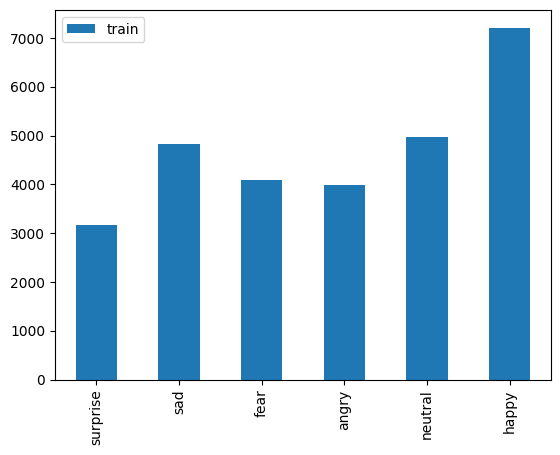

In [ ]:
train_count.transpose().plot(kind='bar')

<h3>Plotting One Image from each Emotion</h3>

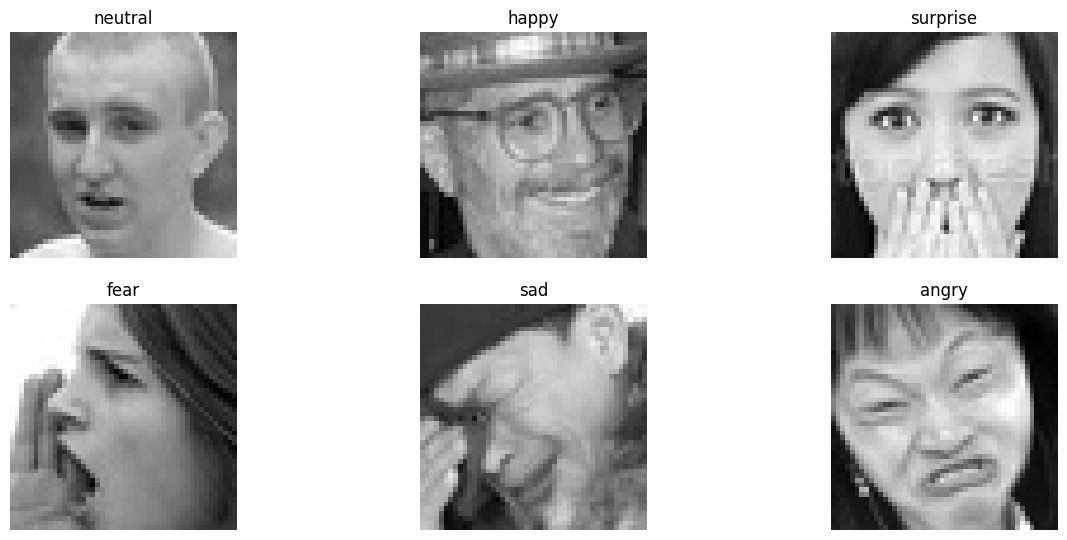

In [ ]:
train_dir = '/content/train'
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i,emotion in enumerate(emotions,1):
  folder_path = os.path.join(train_dir,emotion)
  img_path = os.path.join(folder_path,os.listdir(folder_path)[41])

  img = plt.imread(img_path)
  plt.subplot(3,3,i)
  plt.imshow(img,cmap='gray')
  plt.title(emotion)
  plt.axis('off')

<h3>Randomly Plotiing image from a emotion</h3>

In [ ]:
def random_image_plot(directory,class_name,num_img=9):
  image_file = os.listdir(directory)

  if len(image_file)<num_img:
    print('we have {} images only , plotting all of them'.format(len(image_file)))
    num_img = len(image_file)

  selected_images = random.sample(image_file,num_img)
  fig,axes = plt.subplots(3,3,figsize=(5,5),dpi=80)
  ax = axes.ravel()
  for i,img in enumerate(selected_images):
    image_path = os.path.join(directory,img)
    image = plt.imread(image_path)
    ax[i].imshow(image,cmap='gray')
    ax[i].set_title(class_name)
    ax[i].axis('off')
  plt.tight_layout()
  plt.show()

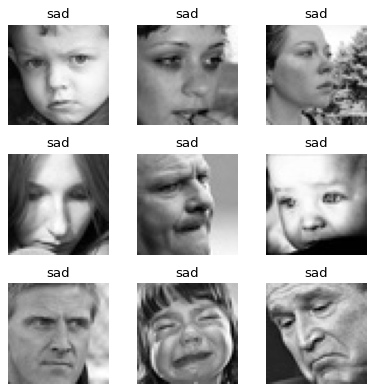

In [ ]:
random_image_plot('/content/train/sad',class_name='sad')

In [ ]:
img = '/content/train/angry/Training_10118481.jpg'

plt.imread(img).shape , cv2.imread(img).shape          # getting image shape using matplotlib's imread() and cv2 's imread()

((48, 48), (48, 48, 3))

<h2>Model 1 -> CNN from Scratch</h2>

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size = 64,
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size = 64,
    subset='validation'
)

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(48,48),
    color_mode = 'grayscale',
    batch_size = 64
)

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [ ]:
print('Training class labels : ',train_generator.class_indices)
print('Validation class labels : ',validation_generator.class_indices)
print('Test class labels : ',test_generator.class_indices)

Training class labels :  {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}
Validation class labels :  {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}
Test class labels :  {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


In [ ]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(48,48,1),kernel_initializer='glorot_uniform',padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(128,kernel_size=(3,3),kernel_regularizer = l2(0.01),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
#model.add(Dropout(0.3))


model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(6))
model.add(Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 5, 512)           │              

 Total params: 17,049,606 (65.04 MB)

 Trainable params: 17,045,894 (65.02 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'],loss='categorical_crossentropy')

In [ ]:
# store this architecture to the cnn model from scratch directory
plot_model(model,to_file='/content/FER-2013_models/Custom_CNN_from_Scratch/model_summary.png',show_layer_names=True,show_shapes=True)

<h3>Understanding Callbacks</h3>

In [ ]:
custom_cnn_path = '/content/FER-2013_models/Custom_CNN_from_Scratch'
best_model = 'best_CNN_model.keras'                                    # read documentation '.keras' extension is necessary

CNN_best_model = os.path.join(custom_cnn_path,best_model)
CNN_best_model

'/content/FER-2013_models/Custom_CNN_from_Scratch/best_CNN_model.keras'

In [ ]:
# after every epoch if the value of parameter that is to be monitored improved , then we save it as the best model so far
checkpoint = ModelCheckpoint(
    filepath=CNN_best_model,
    verbose=1,
    save_best_only=True,
)

In [ ]:
early_stop = EarlyStopping(
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
# reduce the value of LR over the epochs
reduceLR = ReduceLROnPlateau(
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)

In [ ]:
# keep the track of loss,val_loss,accuracy,val_accuracy after every epoch in the training.log
csv_logger = CSVLogger(os.path.join(custom_cnn_path,'training.log'))

In [ ]:
callbacks = [checkpoint, early_stop, reduceLR, csv_logger]

<h3>Training CNN Custom model</h3>

In [ ]:
custom_cnn_history = model.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=callbacks)

Epoch 1/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2496 - loss: 12.9193
Epoch 1: val_loss improved from inf to 12.00726, saving model to /content/FER-2013_models/Custom_CNN_from_Scratch/best_CNN_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 59s 142ms/step - accuracy: 0.2497 - loss: 12.9178 - val_accuracy: 0.1449 - val_loss: 12.0073 - learning_rate: 1.0000e-04
Epoch 2/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3521 - loss: 10.8326
Epoch 2: val_loss improved from 12.00726 to 9.48631, saving model to /content/FER-2013_models/Custom_CNN_from_Scratch/best_CNN_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 51s 67ms/step - accuracy: 0.3522 - loss: 10.8312 - val_accuracy: 0.3755 - val_loss: 9.4863 - learning_rate: 1.0000e-04
Epoch 3/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4176 - loss: 8.9130
Epoch 3: val_loss improved from 9.48631 to 7.61978, saving model to /content/FER-2013_models/Custom_CNN_from_Scratch/best_CNN_model.keras
354/354 ━━━━━━━━━━━━━━━━━━

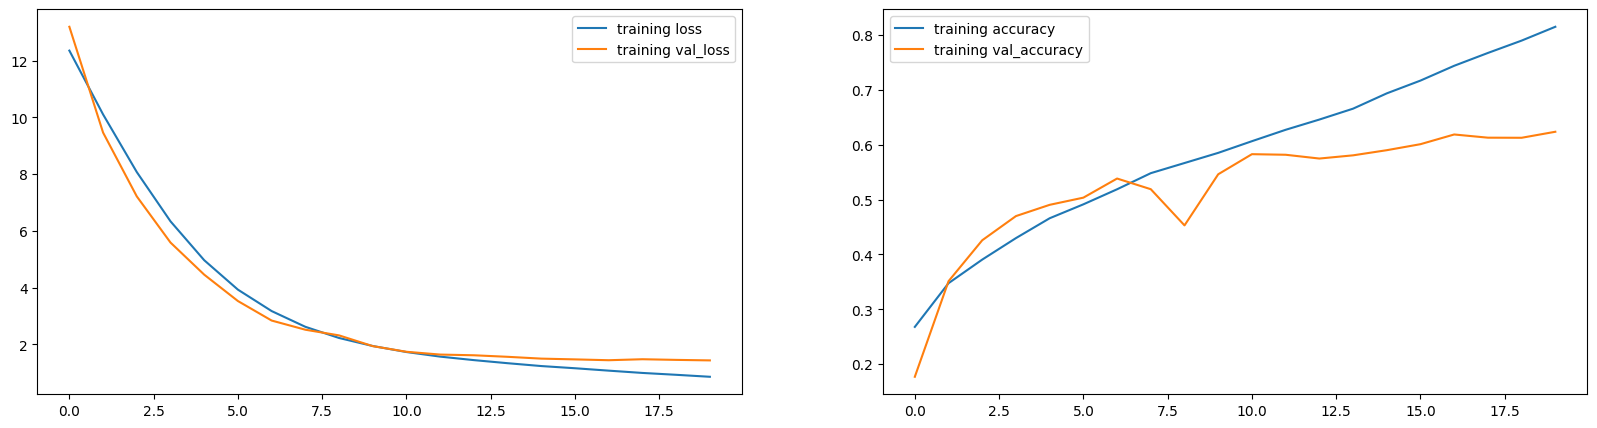

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.plot(custom_cnn_history.history['loss'],label='training loss')
plt.plot(custom_cnn_history.history['val_loss'] , label='training val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(custom_cnn_history.history['accuracy'],label='training accuracy')
plt.plot(custom_cnn_history.history['val_accuracy'],label='training val_accuracy')

plt.legend()
plt.show()

<h3>Plot the Confusion Matrix</h3>

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


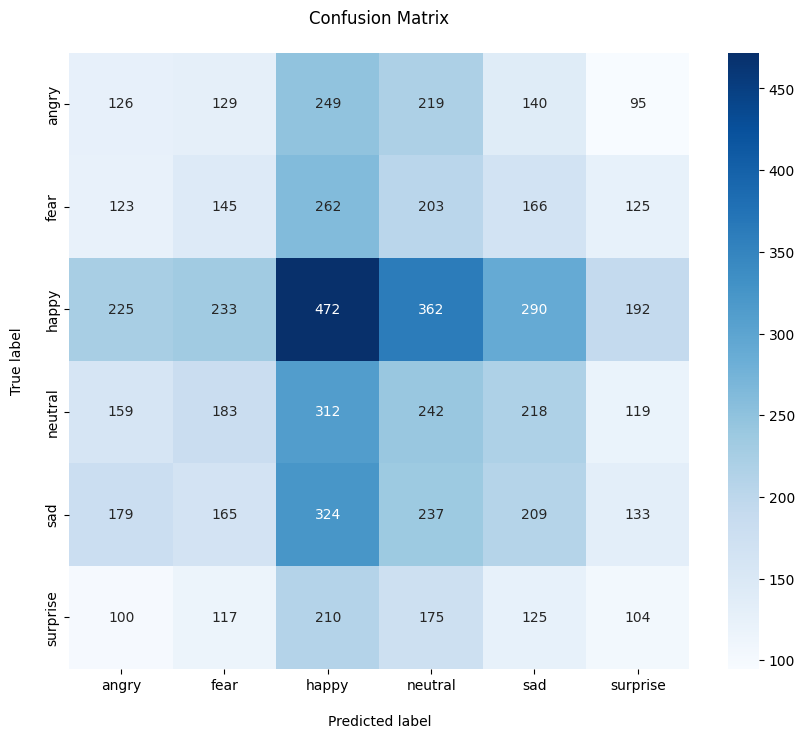

In [ ]:
true_class = test_generator.classes
predicted_class = np.argmax(model.predict(test_generator),axis=1)
class_labels = list(test_generator.class_indices.keys())

cm=confusion_matrix(true_class,predicted_class)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,xticklabels=class_labels,yticklabels=class_labels,fmt='d',cmap='Blues')
plt.title('Confusion Matrix\n')
plt.ylabel('True label\n')
plt.xlabel('\nPredicted label')
plt.show()

In [ ]:
report = classification_report(true_class,predicted_class,target_names=class_labels)
print(report)
# we can observe that we ain;t able to correctly predict any of the disgust class. i.e recall is 0

              precision    recall  f1-score   support

       angry       0.14      0.13      0.13       958
        fear       0.15      0.14      0.15      1024
       happy       0.26      0.27      0.26      1774
     neutral       0.17      0.20      0.18      1233
         sad       0.18      0.17      0.17      1247
    surprise       0.14      0.13      0.13       831

    accuracy                           0.18      7067
   macro avg       0.17      0.17      0.17      7067
weighted avg       0.18      0.18      0.18      7067



In [ ]:
print('a single Batch contains this many image (BatchSize):',test_generator.batch_size)
print('Total No. of Batches',len(test_generator))
print('First Batch has this many entity:',len(test_generator[0]))
print('First Batch\'s first entity has this many images:',len(test_generator[0][0]))
print('First Batch\'s second entity has this many image labels:',len(test_generator[0][1]))
print('First Batch\'s first entity which are images, where each image is of size:',len(test_generator[0][0][0]))
print('First Batch\'s second entity which are image labels, have size of:',len(test_generator[0][1][0]))

a single Batch contains this many image (BatchSize): 64
Total No. of Batches 113
First Batch has this many entity: 2
First Batch's first entity has this many images: 64
First Batch's second entity has this many image labels: 64
First Batch's first entity which are images, where each image is of size: 48
First Batch's second entity which are image labels, have size of: 7


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


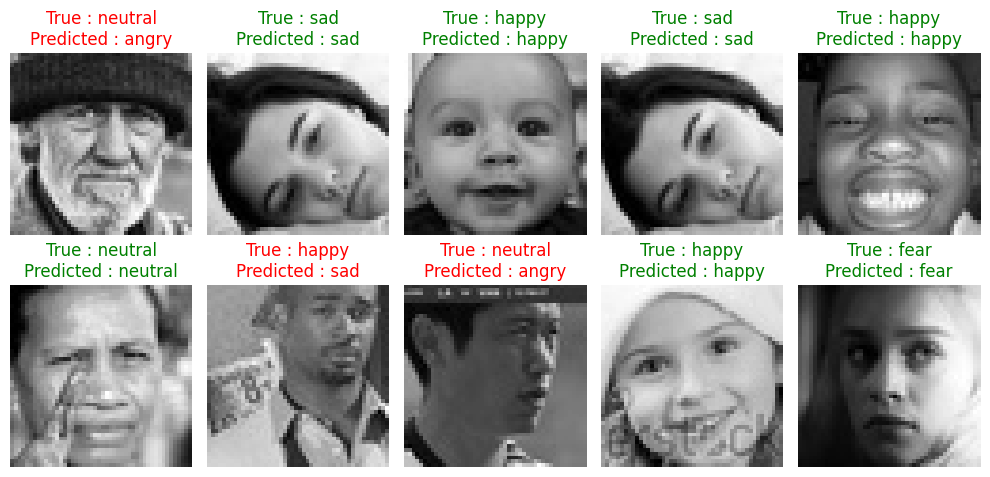

In [ ]:
Emotions = ['angry','fear','happy','neutral','sad','surprise']

random_batch = np.random.randint(0,len(test_generator)-1)            # randomly selecting Batch
random_images = np.random.randint(0,test_generator.batch_size,10)        # randomly selecting 10 image index

fig,axes = plt.subplots(2,5,figsize=(10,5))
axs = axes.ravel()

for i,ax in enumerate(axs):
  image = test_generator[random_batch][0][random_images[i]]          # selecting the image from the randomly choosen batch
  image_label = np.argmax(test_generator[random_batch][1][random_images[i]],axis=0)  # Getting known to the label of the image
  predicted_label = np.argmax(model.predict(np.expand_dims(image,axis=0)))            # predicting the emotion from our model

  color = 'green' if image_label == predicted_label else 'red'     # if prediction is right color is green else it is red
  ax.imshow(image,cmap='gray')
  ax.set_title('True : {}\nPredicted : {}'.format(Emotions[image_label],Emotions[predicted_label]),color=color)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9249 - loss: 0.6171
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6335 - loss: 1.4070
final train accuracy = 92.51 , validation accuracy = 62.80


<h2>Model with Data Augmentation</h2>

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'

data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
 #   height_shift_range=0.2,
    rescale=1./255,
  #  shear_range=0.2,
  #  zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_data_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    subset='training',
)

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    subset='validation',
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
)

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


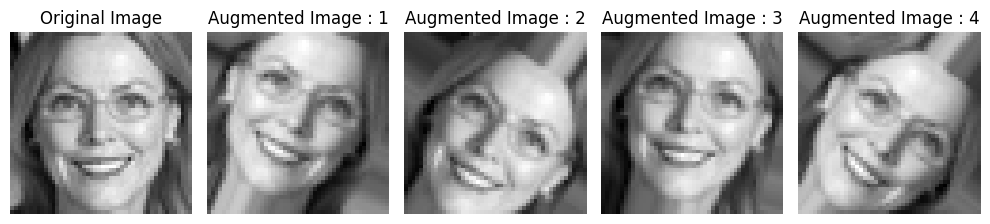

In [ ]:
img_path = '/content/train/happy/Training_1018317.jpg'
img = load_img(img_path,color_mode='grayscale',target_size=(48,48),)
img_array = img_to_array(img)
img_array = img_array.reshape((1,)+img_array.shape)

fig,axes = plt.subplots(1,5,figsize=(10,4))
axs = axes.ravel()

axs[0].imshow(img_array[0],cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

for i,ax in enumerate(axs[1:]):
  aug_iter = data_generator.flow(img_array,batch_size=1)
  aug_img = next(aug_iter)[0]
  ax.imshow(aug_img,cmap='gray')
  ax.set_title('Augmented Image : {}'.format(i+1))
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(48,48,1),kernel_initializer='glorot_uniform',padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),kernel_regularizer = l2(0.01),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(6))
model.add(Activation('softmax'))


model.compile(optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'],loss='categorical_crossentropy')
plot_model(model,to_file='/content/FER-2013_models/Custom_CNN_using_Augmentation/model_summary.png',show_layer_names=True,show_shapes=True)

custom_cnn_path = '/content/FER-2013_models/Custom_CNN_using_Augmentation'
best_model = 'best_CNN_AUG_model.keras'                                    # read documentation '.keras' extension is necessary

CNN_AUG_best_model = os.path.join(custom_cnn_path,best_model)

checkpoint = ModelCheckpoint(
    filepath=CNN_AUG_best_model,
    verbose=1,
    save_best_only=True,
)
early_stop = EarlyStopping(
    patience=3,
    verbose=1,
    restore_best_weights=True
)
reduceLR = ReduceLROnPlateau(
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)
csv_logger = CSVLogger(os.path.join(custom_cnn_path,'training.log'))
callbacks = [checkpoint, early_stop, reduceLR, csv_logger]


custom_aug_cnn_history = model.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=callbacks)

Epoch 1/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.2162 - loss: 13.3449
Epoch 1: val_loss improved from inf to 11.92300, saving model to /content/FER-2013_models/Custom_CNN_using_Augmentation/best_CNN_AUG_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 67s 166ms/step - accuracy: 0.2162 - loss: 13.3423 - val_accuracy: 0.2306 - val_loss: 11.9230 - learning_rate: 1.0000e-04
Epoch 2/30
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2554 - loss: 10.7858
Epoch 2: val_loss improved from 11.92300 to 9.86520, saving model to /content/FER-2013_models/Custom_CNN_using_Augmentation/best_CNN_AUG_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.2554 - loss: 10.7829 - val_accuracy: 0.2642 - val_loss: 9.8652 - learning_rate: 1.0000e-04
Epoch 3/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2812 - loss: 8.7135
Epoch 3: val_loss improved from 9.86520 to 7.51190, saving model to /content/FER-2013_models/Custom_CNN_using_Augmentation/best_CNN_AUG_model.ke

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


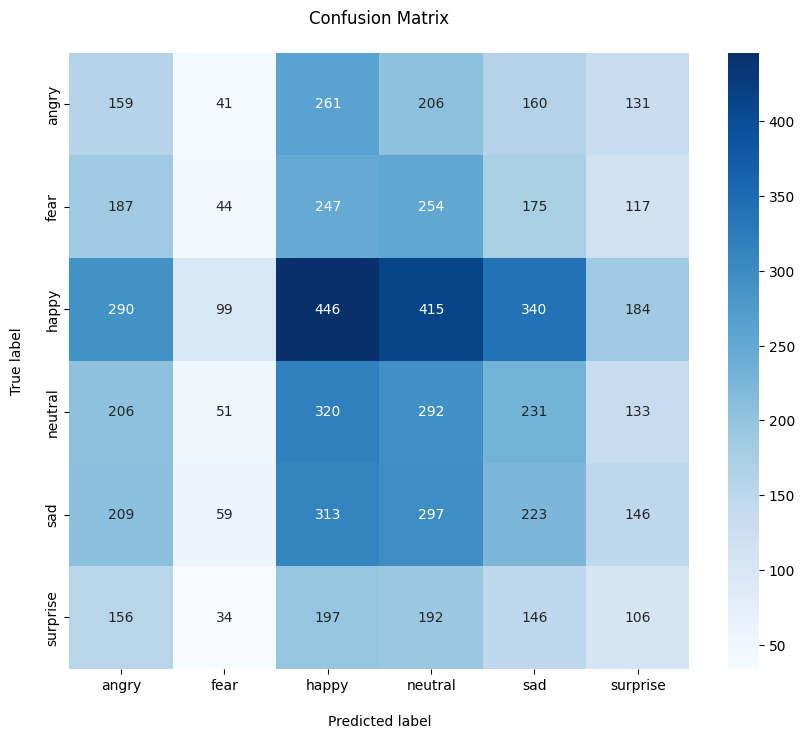

In [ ]:
true_class = test_generator.classes
predicted_class = np.argmax(model.predict(test_generator),axis=1)
class_labels = list(test_generator.class_indices.keys())

cm=confusion_matrix(true_class,predicted_class)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,xticklabels=class_labels,yticklabels=class_labels,fmt='d',cmap='Blues')
plt.title('Confusion Matrix\n')
plt.ylabel('True label\n')
plt.xlabel('\nPredicted label')
plt.show()

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.6078 - loss: 1.1961
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6131 - loss: 1.1882
final train accuracy = 61.17 , validation accuracy = 60.73


<h2>Model Using VGGNET</h2>

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'

data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
  #  height_shift_range=0.1,
    rescale=1./255,
  #  zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_data_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    subset='training',
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [ ]:
vgg = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in vgg.layers[:-3]:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)

x = Dense(1024,activation = 'relu',kernel_initializer ='he_normal')(x)
#x = Dropout(0.5)(x)

x = Dense(512 , activation='relu',kernel_initializer = 'he_normal')(x)
#x=Dropout(0.5)(x)

output = Dense(6,activation='softmax' , kernel_initializer = 'he_normal')(x)

model = Model(inputs=vgg.input,outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'],loss='categorical_crossentropy')

model.summary()

Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,933,702 (156.15 MB)

 Trainable params: 30,938,630 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
plot_model(model,to_file='/content/FER-2013_models/VGG16_transer_learning/model_summary.png',show_layer_names=True,show_shapes=True)

custom_vgg_path = '/content/FER-2013_models/VGG16_transer_learning'
best_model = 'best_VGG_model.keras'                                    # read documentation '.keras' extension is necessary

VGG_best_model = os.path.join(custom_vgg_path,best_model)

checkpoint = ModelCheckpoint(
    filepath=VGG_best_model,
    verbose=1,
    save_best_only=True,
)
early_stop = EarlyStopping(
    patience=3,
    verbose=1,
    restore_best_weights=True
)
reduceLR = ReduceLROnPlateau(
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)
csv_logger = CSVLogger(os.path.join(custom_vgg_path,'training.log'))
callbacks = [checkpoint, early_stop, reduceLR, csv_logger]

In [ ]:
model.fit(train_generator,epochs=20,validation_data=test_generator,callbacks=callbacks)

Epoch 1/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.3807 - loss: 1.5412
Epoch 1: val_loss improved from inf to 1.17396, saving model to /content/FER-2013_models/VGG16_transer_learning/best_VGG_model.keras
442/442 ━━━━━━━━━━━━━━━━━━━━ 459s 968ms/step - accuracy: 0.3809 - loss: 1.5408 - val_accuracy: 0.5400 - val_loss: 1.1740 - learning_rate: 1.0000e-04
Epoch 2/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.5454 - loss: 1.1630
Epoch 2: val_loss improved from 1.17396 to 1.12163, saving model to /content/FER-2013_models/VGG16_transer_learning/best_VGG_model.keras
442/442 ━━━━━━━━━━━━━━━━━━━━ 446s 895ms/step - accuracy: 0.5454 - loss: 1.1630 - val_accuracy: 0.5560 - val_loss: 1.1216 - learning_rate: 1.0000e-04
Epoch 3/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.5844 - loss: 1.0733
Epoch 3: val_loss improved from 1.12163 to 1.07005, saving model to /content/FER-2013_models/VGG16_transer_learning/best_VGG_model.keras
442/442 ━━━━━━━━━━━━━━━━━━━━ 44

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)

113/113 [==============================] - 29s 257ms/step - loss: 1.0820 - accuracy: 0.5961


In [ ]:
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

final train accuracy = 63.04 , validation accuracy = 59.61


<h2>Model Training with ResNet</h2>



In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_data_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    subset='training',
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


<h4>Weights for Imbalanced Data</h4>

In [ ]:
classes = np.array(train_generator.classes)
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(classes),
    y=classes
)

weights_dict = dict(enumerate(class_weights))
print("Class Weights Dictionary:", weights_dict)

Class Weights Dictionary: {0: 1.1795160617438465, 1: 1.1501505166381905, 2: 0.6531069531069531, 3: 0.9490768714333669, 4: 0.9756038647342995, 5: 1.486019131714496}


In [ ]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))

model = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
            #        Dropout(0.1),
                    Dense(256, activation='relu'),
            #        Dropout(0.1),
                    Dense(128, activation='relu'),
             #       Dropout(0.1),
                    Dense(6, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,787,078 (94.56 MB)

 Trainable params: 24,737,542 (94.37 MB)

 Non-trainable params: 49,536 (193.50 KB)

In [ ]:
plot_model(model,to_file='/content/FER-2013_models/ResNetV2_transfer_learning/model_summary.png',show_layer_names=True,show_shapes=True)

custom_resnet_path = '/content/FER-2013_models/ResNetV2_transfer_learning'
best_model = 'best_RESNet_model.keras'                                    # read documentation '.keras' extension is necessary

RESNET_best_model = os.path.join(custom_resnet_path,best_model)

checkpoint = ModelCheckpoint(
    filepath=RESNET_best_model,
    verbose=1,
    save_best_only=True,
)
early_stop = EarlyStopping(
    patience=3,
    verbose=1,
    restore_best_weights=True
)
reduceLR = ReduceLROnPlateau(
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)
csv_logger = CSVLogger(os.path.join(custom_resnet_path,'training.log'))
callbacks = [checkpoint, early_stop, reduceLR, csv_logger]

In [ ]:
for layer in base_model.layers[:-3]:
  layer.trainable = False

In [ ]:
model.fit(train_generator,epochs=10,validation_data=test_generator,callbacks=callbacks,class_weight=weights_dict)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


884/884 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.2396 - loss: 1.7387
Epoch 1: val_loss improved from inf to 1.52900, saving model to /content/FER-2013_models/ResNetV2_transfer_learning/best_RESNet_model.keras
884/884 ━━━━━━━━━━━━━━━━━━━━ 438s 470ms/step - accuracy: 0.2397 - loss: 1.7387 - val_accuracy: 0.4125 - val_loss: 1.5290 - learning_rate: 1.0000e-04
Epoch 2/15
883/884 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.3517 - loss: 1.5901
Epoch 2: val_loss improved from 1.52900 to 1.44084, saving model to /content/FER-2013_models/ResNetV2_transfer_learning/best_RESNet_model.keras
884/884 ━━━━━━━━━━━━━━━━━━━━ 414s 452ms/step - accuracy: 0.3517 - loss: 1.5900 - val_accuracy: 0.4389 - val_loss: 1.4408 - learning_rate: 1.0000e-04
Epoch 3/15
884/884 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.3807 - loss: 1.5416
Epoch 3: val_loss improved from 1.44084 to 1.40336, saving model to /content/FER-2013_models/ResNetV2_transfer_learning/best_RESNet_model.keras
884/884 ━━━━━━━━━━━━━

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 22s 95ms/step - loss: 0.9649 - accuracy: 0.6414
final train accuracy = 66.54 , validation accuracy = 64.14


In [ ]:
# if in case we have to halt the training of model , then we can save them and train them again from the state were it left.

model.save('path to model')  # we basically saved the model
new_model = keras.saving.load_model('model saved path')   # we are retrieving the previously saved model
new_model.fit(train_generator,validation_split=0.2,epochs=10,callbacks = callback)  # we continue the training of the saved model

In [ ]:
model.save('best_CNN_model.keras')